In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

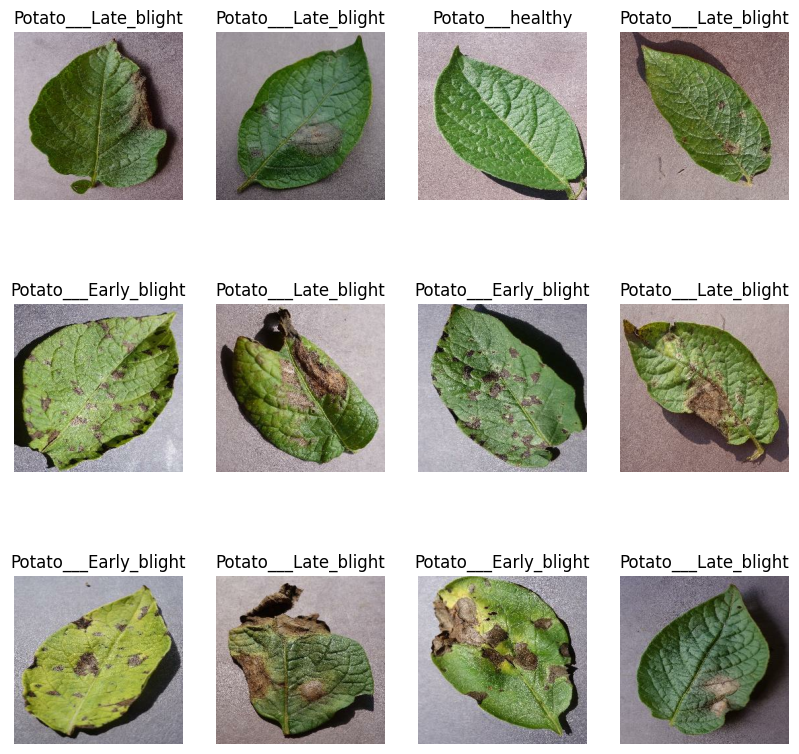

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.xlabel(class_names[labels_batch[i]])
        plt.axis("off")
    plt.show()

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model
80% ==> tranning
20% ==> 10% validation, 10% test (measure accuracy)

In [8]:
train_size = 0.8
len(dataset)* train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
remainning_ds = dataset.skip(54)
len(remainning_ds)

14

In [11]:
validation_size = 0.1
len(dataset) * validation_size

6.800000000000001

In [12]:
validation_ds = remainning_ds.take(6)
len(validation_ds)

6

In [13]:
test_ds = remainning_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions(dataset, train_split=0.8, validation_split=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    ds_size =  len(dataset)
    if shuffle:
        ds = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * validation_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions(dataset)

In [16]:
len(dataset)
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

Cache, Shuffle, and Prefetch the Dataset

In [17]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Building the Model

Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to
improve model performance, we should normalize the image pixel value (keeping them in range 0 and
1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as
a layer in our Sequential Model.
You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we
don't need to but this will be useful when we are done with the training and start using the model for
predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [19]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ]
)

Applying Data Augmentation to Train Dataset

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for
resizing, normalization and Data Augmentation.

In [21]:
image_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, 3, activation='relu', input_shape=image_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=image_shape)

d:\Deep-learning-project-Potato-Disease-Classification-Using-CNN\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 50176)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 512)              │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,080,579 (99.49 MB)

 Trainable params: 26,080,579 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model

We use adam Optimizer, Sparsecategoricalcrossentropy for losses, accuracy as a metric

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.5098 - loss: 0.9662 - val_accuracy: 0.8229 - val_loss: 0.4836
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8550 - loss: 0.3907 - val_accuracy: 0.8512 - val_loss: 0.5592
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8708 - loss: 0.3838 - val_accuracy: 0.7656 - val_loss: 0.6066
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9257 - loss: 0.1943 - val_accuracy: 0.8490 - val_loss: 0.4587
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9363 - loss: 0.1994 - val_accuracy: 0.8438 - val_loss: 0.4882
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9404 - loss: 0.1688 - val_accuracy: 0.8698 - val_loss: 0.3181
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9484 - loss: 0.1333 - val_accuracy: 0.8906 - val_loss: 0.2421
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9412 - loss: 0.1458 - val_accuracy: 0.8750 - val_lo

In [25]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 353ms/step - accuracy: 0.9832 - loss: 0.0594


In [26]:
scores

[0.048968639224767685, 0.984375]

Scores is just a list containing loss and accuracy value

Plotting the Accuracy and Loss Curves

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of
each epoch

In [30]:
len(history.history['accuracy'])

50

In [36]:
history.history['loss']

[0.7725281715393066,
 0.4108763635158539,
 0.3357847332954407,
 0.19237257540225983,
 0.16488221287727356,
 0.20198114216327667,
 0.13956701755523682,
 0.1294003278017044,
 0.17545107007026672,
 0.15617017447948456,
 0.08742371946573257,
 0.16148662567138672,
 0.09209667891263962,
 0.11184356361627579,
 0.10454391688108444,
 0.09328565746545792,
 0.05996480956673622,
 0.07621849328279495,
 0.0960073247551918,
 0.09571947902441025,
 0.10362431406974792,
 0.06840105354785919,
 0.06563213467597961,
 0.10942861437797546,
 0.1139497458934784,
 0.08870523422956467,
 0.06725716590881348,
 0.09174381196498871,
 0.0909014344215393,
 0.06353927403688431,
 0.05580681189894676,
 0.10798007994890213,
 0.0694405660033226,
 0.05816379189491272,
 0.04593708738684654,
 0.1413004845380783,
 0.07893432676792145,
 0.04731018468737602,
 0.08948322385549545,
 0.07326085865497589,
 0.05162995308637619,
 0.0398528091609478,
 0.03916066139936447,
 0.06843088567256927,
 0.03637753427028656,
 0.04439204558730125

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

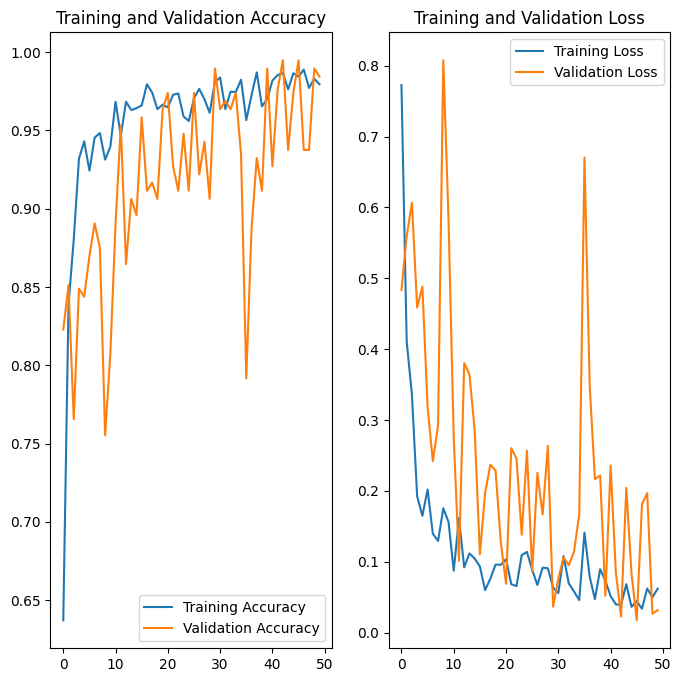

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: Potato___Late_blight


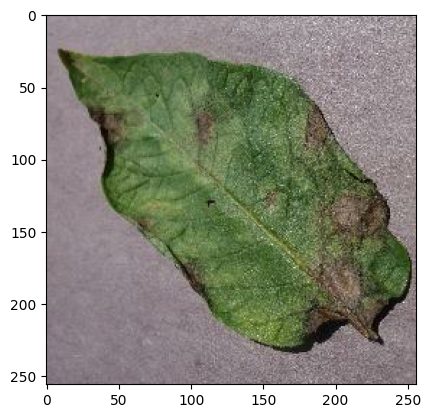

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


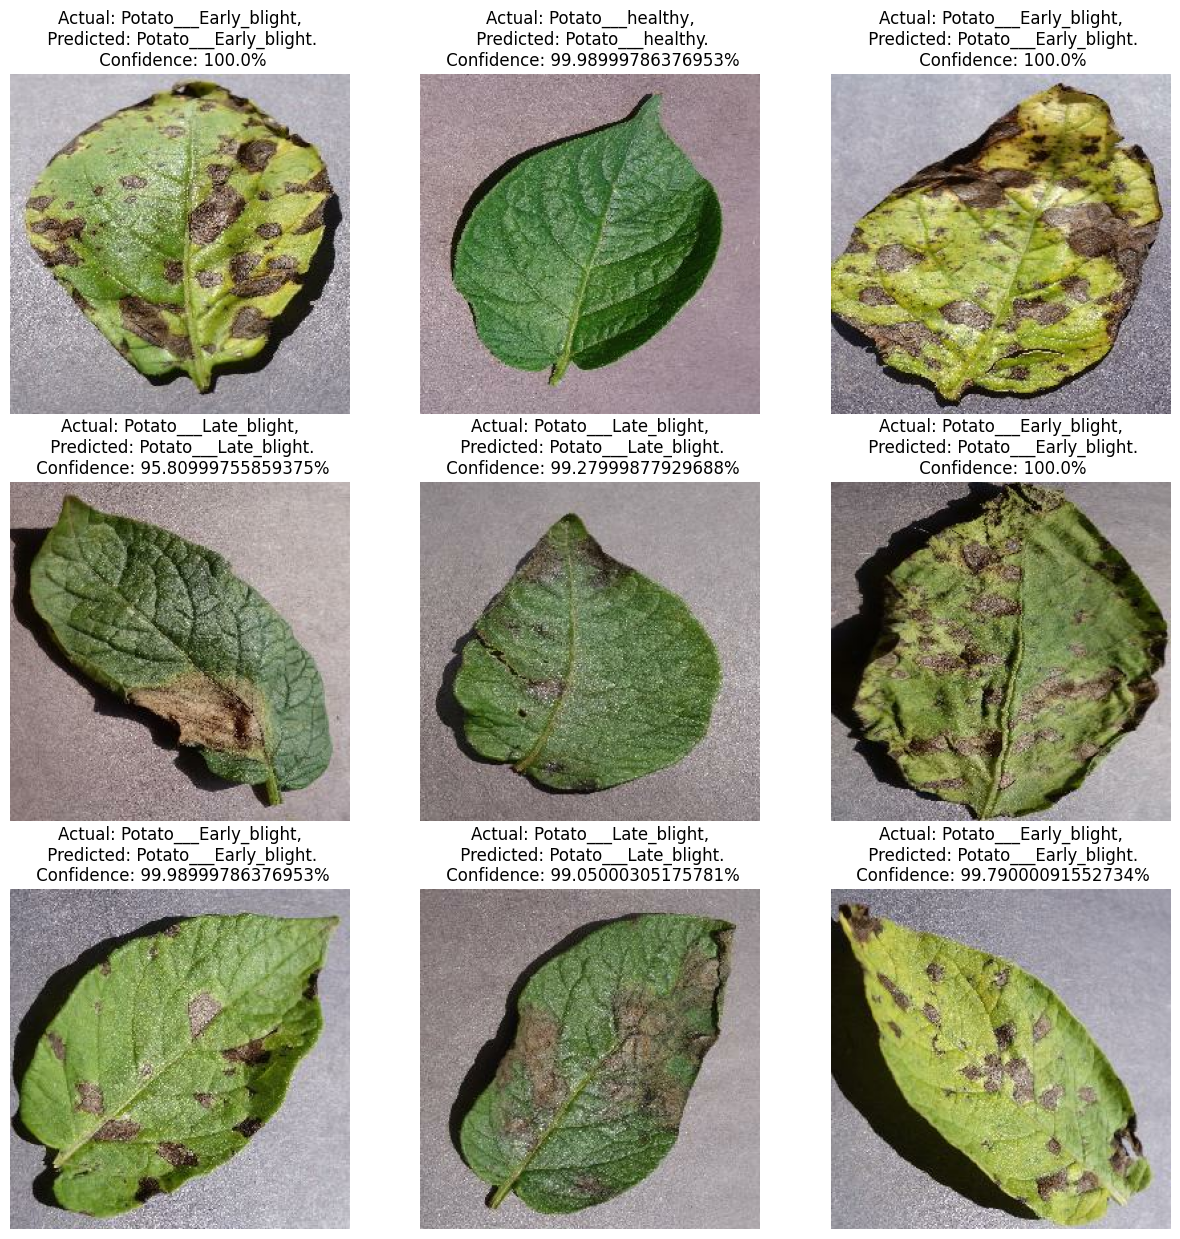

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [42]:
model.save("../potatoes.h5")